In [60]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import scipy.stats
import itertools
import string
import matplotlib.patches
import netCDF4
import cftime
import seaborn
import cmocean
import matplotlib.gridspec
import scipy.interpolate

import glob
import pandas

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [163]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-7.5,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-7.5,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

calculate latitude information

In [3]:
lat_lo_open = -35.
lat_hi_open = 35.
lat_lo = -10.
lat_hi = 10.
lon_lo = 270.
lon_hi = 330.

# 10year simulations

400 clm runs

In [61]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
cont_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False, decode_cf=False, concat_dim='time')

In [95]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm0400/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
cont_clm_ds_list = [xarray.open_dataset(file, decode_times=False) for file in file_list]

In [139]:
SOILLIQ_400_list = [f['SOILLIQ'].values for f in cont_clm_ds_list]
SOILWATER_400_list = [f['SOILWATER_10CM'].values for f in cont_clm_ds_list]

get lat/lon info

In [152]:
lat = cont_clm_ds_list[0]['lat'].sel(lat=slice(lat_lo_open,lat_hi_open)).values
lon = cont_clm_ds_list[0]['lon'].sel(lon=slice(lon_lo,lon_hi)).values

lon_total = cont_clm_ds_list[0]['lon'].values
lat_total = cont_clm_ds_list[0]['lat'].values

lat_indices = (lat>=lat_lo)&(lat<=lat_hi)
lat_indices_open = (lat>=lat_lo_open)&(lat<=lat_hi_open)
lon_indices = (lon>=lon_lo)&(lon<=lon_hi)

lat_subset = lat[lat_indices]
lon_subset = lon[lon_indices]

lat_subset_open = lat[lat_indices_open]

get time info

In [65]:
time_400_list = [netCDF4.num2date(ds['time'].values, \
                                  ds['time'].units, \
                                  ds['time'].calendar) \
                 for ds in cont_clm_ds_list]

In [66]:
time_400_array = numpy.array([ t for sublist in time_400_list for t in sublist ])

In [78]:
time_400 = cont_cam_mfds['time']
time_converted = netCDF4.num2date(time_400.values, time_400.units, time_400.calendar)

time_manual = []
for t_idx in range(time_converted.size):
    year=time_converted[t_idx].year
    month=time_converted[t_idx].month
    day=time_converted[t_idx].day
    hour=time_converted[t_idx].hour
    minute=time_converted[t_idx].minute
    hour_round = round(hour+minute/60)
    time_manual.append(cftime.DatetimeNoLeap(year,month,day,hour_round))

In [79]:
LANDFRAC = cont_cam_mfds['LANDFRAC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values[0,:,:]

In [80]:
PRECC_400_10y = cont_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_400_10y = cont_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_400_10y = PRECC_400_10y+PRECL_400_10y

1000 clm runs

In [81]:
data_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
phys_cam_mfds = xarray.open_mfdataset(data_dir + 'atm/hist/*.nc', decode_times=False, parallel=True)

In [112]:
root_dir = '/beegfs/DATA/pritchard/blangenb/CESM_ARCHIVE/B_1850_CAM5.10years.cam0400.clm1000/'
file_list = sorted(glob.glob(root_dir+'lnd/hist/*.nc'))
phys_clm_ds_list = [xarray.open_dataset(file, decode_times=False) for file in file_list]

In [218]:
soil_levels = phys_clm_ds_list[0]['levgrnd'].values # units: meters

In [140]:
SOILLIQ_1000_list = [f['SOILLIQ'].values for f in phys_clm_ds_list]
SOILWATER_1000_list = [f['SOILWATER_10CM'].values for f in phys_clm_ds_list]

In [83]:
PRECC_1000_10y = phys_cam_mfds['PRECC'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECL_1000_10y = phys_cam_mfds['PRECL'].sel(lat=slice(lat_lo_open,lat_hi_open),lon=slice(lon_lo,lon_hi)).values
PRECT_1000_10y = PRECC_1000_10y+PRECL_1000_10y

take time averages

In [84]:
PRECT_400_timemean_10year = numpy.mean(PRECT_400_10y, axis=0)
PRECT_1000_timemean_10year = numpy.mean(PRECT_1000_10y, axis=0)

In [85]:
PRECT_400_timemean_10year_landmask = numpy.copy(PRECT_400_timemean_10year)
PRECT_1000_timemean_10year_landmask = numpy.copy(PRECT_1000_timemean_10year)

PRECT_400_timemean_10year_landmask[LANDFRAC==0] = numpy.nan
PRECT_1000_timemean_10year_landmask[LANDFRAC==0] = numpy.nan

# calculate all differences

precip

In [86]:
PRECT_diffs_10year = PRECT_1000_timemean_10year_landmask-PRECT_400_timemean_10year_landmask

soil moisture

In [142]:
SOILWATER_400 = numpy.concatenate(SOILWATER_400_list, axis=0)
SOILWATER_1000 = numpy.concatenate(SOILWATER_1000_list, axis=0)

In [212]:
SOILLIQ_400 = numpy.concatenate(SOILLIQ_400_list, axis=0)
SOILLIQ_1000 = numpy.concatenate(SOILLIQ_1000_list, axis=0)

In [143]:
SOILWATER_400_timemean = numpy.nanmean(SOILWATER_400, axis=0)
SOILWATER_1000_timemean = numpy.nanmean(SOILWATER_1000, axis=0)
SOILWATER_diffs_10year = SOILWATER_1000_timemean-SOILWATER_400_timemean

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [219]:
SOILLIQ_400_timemean = numpy.nanmean(SOILLIQ_400, axis=0)
SOILLIQ_1000_timemean = numpy.nanmean(SOILLIQ_1000, axis=0)
SOILLIQ_diffs_10year = SOILLIQ_1000_timemean-SOILLIQ_400_timemean

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


# plot 10-year mean changes

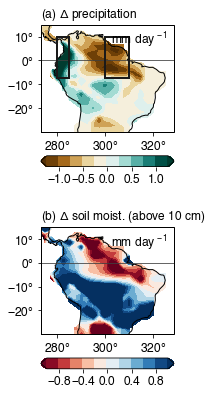

In [220]:
# MONTHLY MEAN PLOTS

fig = mp.figure(figsize=(2.667,6))
fontsize = 12
lon_offset=25.

# PRECIP DIFFS

levels = numpy.arange(-1.25,1.251,0.25)
ax1 = fig.add_subplot(211, projection=cartopy.crs.PlateCarree())
ax1.gridlines(ylocs=[0], color='0.25')
ax1.coastlines(resolution='110m')
contour_plot1 = ax1.contourf(lon, lat, PRECT_diffs_10year*86400.*1000., \
                             levels=levels, \
                             cmap='BrBG', extend='both', transform=cartopy.crs.PlateCarree())

# ax1.contour(lon,lat,field_convolved*24.,\
#             levels=[4], colors=outline_color, linewidths=[2], linestyles=['-'])

# left patch
ax1.add_patch(matplotlib.patches.Rectangle(xy=[wet_lon_lo, wet_lat_lo], width=(wet_lon_hi-wet_lon_lo), \
                                           height=(wet_lat_hi-wet_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

ax1.add_patch(matplotlib.patches.Rectangle(xy=[dry_lon_lo, dry_lat_lo], width=(dry_lon_hi-dry_lon_lo), \
                                           height=(dry_lat_hi-dry_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

# CHANGE IN SOIL MOISTURE

levels = numpy.arange(-1,1.1,0.2)
ax2 = fig.add_subplot(212, projection=cartopy.crs.PlateCarree())
ax2.gridlines(ylocs=[0], color='0.25')
ax2.coastlines(resolution='110m')
contour_plot2 = ax2.contourf(lon_total, lat_total, SOILWATER_diffs_10year, levels=levels, \
                             cmap='RdBu', extend='both', transform=cartopy.crs.PlateCarree())

ax1.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())
ax2.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())

ax1.set_xticks([-360+280,-360+300,-360+320])
ax1.set_yticks([-20,-10,0,10])
ax1.tick_params(labelsize=fontsize)
ax1.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax1.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax2.set_xticks([-360+280,-360+300,-360+320])
ax2.set_yticks([-20,-10,0,10])
ax2.tick_params(labelsize=fontsize)
ax2.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax2.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

fig.tight_layout(h_pad=0.5,w_pad=0.5)
fig.canvas.draw_idle()

title = ax1.text(s='(a) $\Delta$ precipitation', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
title = ax2.text(s='(b) $\Delta$ soil moist. (above 10 cm)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)

ax1.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax1.transAxes)
ax2.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax2.transAxes)

for c in contour_plot1.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)
for c in contour_plot2.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)

cbar_thickness=0.025
cbar_yshift=-0.08

#fig.tight_layout()

bbox_position = ax1.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot1, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([numpy.arange(-1,1.1,0.5)])
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

bbox_position = ax2.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot2, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

#fig.savefig('../figures/REVISION_fig02.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [222]:
SOILLIQ_diffs_10year.shape

(15, 96, 144)

In [ ]:
# MONTHLY MEAN PLOTS

fig = mp.figure(figsize=(2.667,6))
fontsize = 12
lon_offset=25.

# PRECIP DIFFS

levels = numpy.arange(-1.25,1.251,0.25)
ax1 = fig.add_subplot(211, projection=cartopy.crs.PlateCarree())
ax1.gridlines(ylocs=[0], color='0.25')
ax1.coastlines(resolution='110m')
contour_plot1 = ax1.contourf(lon, lat, PRECT_diffs_10year*86400.*1000., \
                             levels=levels, \
                             cmap='BrBG', extend='both', transform=cartopy.crs.PlateCarree())

# ax1.contour(lon,lat,field_convolved*24.,\
#             levels=[4], colors=outline_color, linewidths=[2], linestyles=['-'])

# left patch
ax1.add_patch(matplotlib.patches.Rectangle(xy=[wet_lon_lo, wet_lat_lo], width=(wet_lon_hi-wet_lon_lo), \
                                           height=(wet_lat_hi-wet_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

ax1.add_patch(matplotlib.patches.Rectangle(xy=[dry_lon_lo, dry_lat_lo], width=(dry_lon_hi-dry_lon_lo), \
                                           height=(dry_lat_hi-dry_lat_lo),
                                facecolor='none',
                                edgecolor='0.1',\
                                linewidth=2,\
                                transform=cartopy.crs.PlateCarree(), zorder=2) )

# CHANGE IN SOIL MOISTURE

levels = numpy.arange(-1,1.1,0.2)
ax2 = fig.add_subplot(212, projection=cartopy.crs.PlateCarree())
ax2.gridlines(ylocs=[0], color='0.25')
ax2.coastlines(resolution='110m')
contour_plot2 = ax2.contourf(lon_total, lat_total, SOILLIQ_diffs_10year, levels=levels, \
                             cmap='RdBu', extend='both', transform=cartopy.crs.PlateCarree())

ax1.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())
ax2.set_extent([273,329,-30,15], crs=cartopy.crs.PlateCarree())

ax1.set_xticks([-360+280,-360+300,-360+320])
ax1.set_yticks([-20,-10,0,10])
ax1.tick_params(labelsize=fontsize)
ax1.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax1.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

ax2.set_xticks([-360+280,-360+300,-360+320])
ax2.set_yticks([-20,-10,0,10])
ax2.tick_params(labelsize=fontsize)
ax2.set_xticklabels(['$280$'+DEGREE_SIGN,'$300$'+DEGREE_SIGN,'$320$'+DEGREE_SIGN])
ax2.set_yticklabels(['$-20$'+DEGREE_SIGN,'$-10$'+DEGREE_SIGN,'$0$'+DEGREE_SIGN,'$10$'+DEGREE_SIGN])

fig.tight_layout(h_pad=0.5,w_pad=0.5)
fig.canvas.draw_idle()

title = ax1.text(s='(a) $\Delta$ precipitation', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax1.transAxes)
title = ax2.text(s='(b) $\Delta$ soil moist. (above 10 cm)', x=0, y=1.02, ha='left', va='bottom', fontsize=fontsize, transform=ax2.transAxes)

ax1.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax1.transAxes)
ax2.text(s='mm day$^{\,-1}$', x=0.95, y=0.95, \
        ha='right', va='top', \
        fontsize=fontsize, \
        transform=ax2.transAxes)

for c in contour_plot1.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)
for c in contour_plot2.collections:
    c.set_edgecolor('face')
    c.set_rasterized(True)

cbar_thickness=0.025
cbar_yshift=-0.08

#fig.tight_layout()

bbox_position = ax1.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot1, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
cbar.set_ticks([numpy.arange(-1,1.1,0.5)])
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

bbox_position = ax2.get_position()
cbar_axes = fig.add_axes([bbox_position.x0, bbox_position.y0+cbar_yshift, bbox_position.width, cbar_thickness])
cbar = mp.colorbar(contour_plot2, orientation='horizontal', cax=cbar_axes)
cbar_axes.tick_params(labelsize=fontsize)
for c in cbar_axes.collections:
    c.set_edgecolor('face')
#     c.set_rasterized(True)

#fig.savefig('../figures/REVISION_fig02.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [185]:
lat_subset_indices_dry = (lat>=dry_lat_lo)&(lat<=dry_lat_hi)
lon_subset_indices_dry = (lon>=dry_lon_lo_degE)&(lon<=dry_lon_hi_degE)

lat_total_indices_dry = (lat_total>=dry_lat_lo)&(lat_total<=dry_lat_hi)
lon_total_indices_dry = (lon_total>=dry_lon_lo_degE)&(lon_total<=dry_lon_hi_degE)

In [190]:
lat_subset_indices_wet = (lat>=wet_lat_lo)&(lat<=wet_lat_hi)
lon_subset_indices_wet = (lon>=wet_lon_lo_degE)&(lon<=wet_lon_hi_degE)

lat_total_indices_wet = (lat_total>=wet_lat_lo)&(lat_total<=wet_lat_hi)
lon_total_indices_wet = (lon_total>=wet_lon_lo_degE)&(lon_total<=wet_lon_hi_degE)

In [191]:
PRECT_1000_dry = PRECT_1000_10y[:,lat_subset_indices_dry,:][:,:,lon_subset_indices_dry]
PRECT_400_dry = PRECT_400_10y[:,lat_subset_indices_dry,:][:,:,lon_subset_indices_dry]

PRECT_1000_wet = PRECT_1000_10y[:,lat_subset_indices_wet,:][:,:,lon_subset_indices_wet]
PRECT_400_wet = PRECT_400_10y[:,lat_subset_indices_wet,:][:,:,lon_subset_indices_wet]

In [195]:
SOILWATER_1000_dry = SOILWATER_1000[:,lat_total_indices_dry,:][:,:,lon_total_indices_dry]
SOILWATER_400_dry = SOILWATER_400[:,lat_total_indices_dry,:][:,:,lon_total_indices_dry]

SOILWATER_1000_wet = SOILWATER_1000[:,lat_total_indices_wet,:][:,:,lon_total_indices_wet]
SOILWATER_400_wet = SOILWATER_400[:,lat_total_indices_wet,:][:,:,lon_total_indices_wet]

In [223]:
SOILLIQ_1000_dry = SOILLIQ_1000[:,:,lat_total_indices_dry,:][:,:,:,lon_total_indices_dry]
SOILLIQ_400_dry = SOILLIQ_400[:,:,lat_total_indices_dry,:][:,:,:,lon_total_indices_dry]

SOILLIQ_1000_wet = SOILLIQ_1000[:,:,lat_total_indices_wet,:][:,:,:,lon_total_indices_wet]
SOILLIQ_400_wet = SOILLIQ_400[:,:,lat_total_indices_wet,:][:,:,:,lon_total_indices_wet]

In [208]:
PRECT_1000_dry_areamean = numpy.nanmean(PRECT_1000_dry, axis=(1,2))
PRECT_400_dry_areamean = numpy.nanmean(PRECT_400_dry, axis=(1,2))

In [200]:
SOILWATER_1000_dry_areamean = numpy.nanmean(SOILWATER_1000_dry, axis=(1,2))
SOILWATER_400_dry_areamean = numpy.nanmean(SOILWATER_400_dry, axis=(1,2))

In [224]:
SOILLIQ_1000_dry_areamean = numpy.nanmean(SOILLIQ_1000_dry, axis=(2,3))
SOILLIQ_400_dry_areamean = numpy.nanmean(SOILLIQ_400_dry, axis=(2,3))

In [225]:
SOILWATER_dry_diffs = SOILWATER_1000_dry_areamean-SOILWATER_400_dry_areamean

PRECT_dry_diffs = PRECT_1000_dry_areamean-PRECT_400_dry_areamean

SOILLIQ_dry_diffs = SOILLIQ_1000_dry_areamean - SOILLIQ_400_dry_areamean

In [206]:
SOILWATER_dry_diffs_rollingmean = pandas.Series(SOILWATER_dry_diffs).rolling(window=365, center=True, min_periods=1).mean()
PRECT_dry_diffs_rollingmean = pandas.Series(PRECT_dry_diffs).rolling(window=365, center=True, min_periods=1).mean()

In [279]:
soil_levels

array([7.10063521e-03, 2.79249996e-02, 6.22585751e-02, 1.18865065e-01,
       2.12193400e-01, 3.66065800e-01, 6.19758487e-01, 1.03802705e+00,
       1.72763526e+00, 2.86460710e+00, 4.73915672e+00, 7.82976627e+00,
       1.29253206e+01, 2.13264694e+01, 3.51776199e+01], dtype=float32)

In [310]:
which_level = 7
SOILLIQ_dry_diffs_rollingmean = pandas.Series(SOILLIQ_dry_diffs[:,which_level]).rolling(window=365, center=True, min_periods=1).mean()

In [329]:
SOILLIQ_dry_diffs.shape

(3651, 15)

In [332]:
numpy.linspace(0,1,15)

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])

In [333]:
SOILLIQ_dry_diffs.shape

(3651, 15)

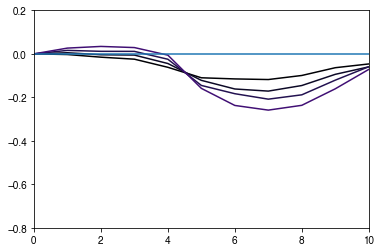

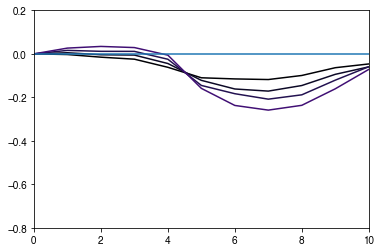

In [357]:
color_list = [matplotlib.cm.magma(i) for i in numpy.linspace(0,1,SOILLIQ_dry_diffs.shape[1])]
for i in range(SOILLIQ_dry_diffs.shape[1])[:4]:
    mp.plot(SOILLIQ_dry_diffs[:,i], color=color_list[i]) #SOILLIQ_dry_diffs[:,1])#
mp.xlim(0,10)
mp.ylim(-.8,.2)
mp.axhline(0)

taking weighted average to group soil levels of CESM into same thresholds as Noah-MP

In [349]:
60e-3

0.06

0.06

In [355]:
soil_levels.shape

(15,)

(15,)

In [354]:
thresholds = [0,10e-3,30e-3,60e-3,100e-3]
for i in range(4):
    soil_levels_indices = (soil_levels>thresholds[i])&(soil_levels<=thresholds[i+1])
    print(sum(soil_levels_indices))

1
1
0
1
1
1
0
1


In [317]:
[matplotlib.cm.magma(i) for i in range(SOILLIQ_dry_diffs.shape[0])]

[(0.001462, 0.000466, 0.013866, 1.0),
 (0.002258, 0.001295, 0.018331, 1.0),
 (0.003279, 0.002305, 0.023708, 1.0),
 (0.004512, 0.00349, 0.029965, 1.0),
 (0.00595, 0.004843, 0.03713, 1.0),
 (0.007588, 0.006356, 0.044973, 1.0),
 (0.009426, 0.008022, 0.052844, 1.0),
 (0.011465, 0.009828, 0.06075, 1.0),
 (0.013708, 0.011771, 0.068667, 1.0),
 (0.016156, 0.01384, 0.076603, 1.0),
 (0.018815, 0.016026, 0.084584, 1.0),
 (0.021692, 0.01832, 0.09261, 1.0),
 (0.024792, 0.020715, 0.100676, 1.0),
 (0.028123, 0.023201, 0.108787, 1.0),
 (0.031696, 0.025765, 0.116965, 1.0),
 (0.03552, 0.028397, 0.125209, 1.0),
 (0.039608, 0.03109, 0.133515, 1.0),
 (0.04383, 0.03383, 0.141886, 1.0),
 (0.048062, 0.036607, 0.150327, 1.0),
 (0.05232, 0.039407, 0.158841, 1.0),
 (0.056615, 0.04216, 0.167446, 1.0),
 (0.060949, 0.044794, 0.176129, 1.0),
 (0.06533, 0.047318, 0.184892, 1.0),
 (0.069764, 0.049726, 0.193735, 1.0),
 (0.074257, 0.052017, 0.20266, 1.0),
 (0.078815, 0.054184, 0.211667, 1.0),
 (0.083446, 0.056225, 0.220

In [273]:
SOILLIQ_dry_diffs_rollingmean

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
3621    0.0
3622    0.0
3623    0.0
3624    0.0
3625    0.0
3626    0.0
3627    0.0
3628    0.0
3629    0.0
3630    0.0
3631    0.0
3632    0.0
3633    0.0
3634    0.0
3635    0.0
3636    0.0
3637    0.0
3638    0.0
3639    0.0
3640    0.0
3641    0.0
3642    0.0
3643    0.0
3644    0.0
3645    0.0
3646    0.0
3647    0.0
3648    0.0
3649    0.0
3650    0.0
Length: 3651, dtype: float64

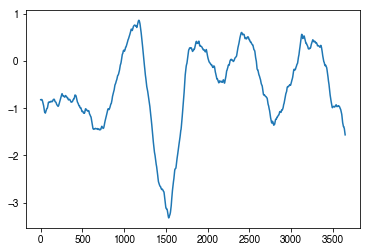

In [207]:
mp.plot(SOILWATER_dry_diffs_rollingmean)

([<matplotlib.axis.XTick at 0x2b105b855fd0>,
 <a list of 11 Text xticklabel objects>)

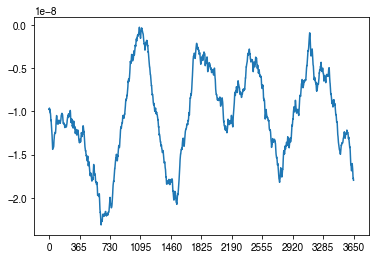

In [282]:
mp.plot(PRECT_dry_diffs_rollingmean)
mp.xticks([i for i in range(0,365*11,365)])

# wrf 50km runs

## 400 data

In [ ]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [ ]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [ ]:
rainc_400 = cont_mfds['RAINC'].values
rainnc_400 = cont_mfds['RAINNC'].values

In [ ]:
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [ ]:
xlat_indices = (xlat>=-10)&(xlat<=10.)

In [ ]:
hgt_50km = cont_mfds['HGT'].sel(Time=0).values

In [ ]:
hgt_50km_landmask = numpy.copy(hgt_50km)
hgt_50km_landmask[landmask==0] = numpy.nan

hgt_50km_landmask_lat_subset = hgt_50km_landmask[xlat_indices[:,0],:]
hgt_50km_latmean = numpy.nanmean(hgt_50km_landmask_lat_subset, axis=0)

## 1000 data

In [ ]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = glob.glob(root_dir+'/'+'wrfout*.nc')
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [ ]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [ ]:
rainc_1000 = phys_mfds['RAINC'].values
rainnc_1000 = phys_mfds['RAINNC'].values

## calculate WRF differences

In [ ]:
raintot_400 = rainc_400+rainnc_400
raintot_1000 = rainc_1000+rainnc_1000

raintot_400_diff = numpy.zeros((raintot_400.shape))*numpy.nan
raintot_400_diff[:-1,:,:] = numpy.diff(raintot_400, axis=0)#*(24./3) # convert to mm/day

raintot_1000_diff = numpy.zeros((raintot_1000.shape))*numpy.nan
raintot_1000_diff[:-1,:,:] = numpy.diff(raintot_1000, axis=0)#*(24./3) # convert to mm/day

# monthly mean
raintot_diffs_time_mean = numpy.nanmean(raintot_1000_diff[skip_time:,:,:] - raintot_400_diff[skip_time:,:,:], axis=0)
raintot_diffs_time_mean_landmask = numpy.copy(raintot_diffs_time_mean)
raintot_diffs_time_mean_landmask[landmask==0] = numpy.nan

raintot_400_time_mean = numpy.nanmean(raintot_400_diff[skip_time:,:,:], axis=0)
raintot_400_time_mean_landmask = numpy.copy(raintot_400_time_mean)
raintot_400_time_mean_landmask[landmask==0] = numpy.nan


In [ ]:
day1_start_hour = 10 #6am = 10:00 because of the time offset
day1_end_hour = 24 #8pm = 24:00 because of time offset
raintot_diffs_time_mean_day1 = numpy.nanmean(raintot_1000_diff[day1_start_hour:day1_end_hour+1,:,:] - raintot_400_diff[day1_start_hour:day1_end_hour+1,:,:], axis=0)
raintot_diffs_time_mean_day1_landmask = numpy.copy(raintot_diffs_time_mean_day1)
raintot_diffs_time_mean_day1_landmask[landmask==0] = numpy.nan

# import WRF 2km days 2-10

In [ ]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/001/'
cont_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [ ]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/001/'
phys_mfds_2km = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [ ]:
raintot_400_2km = cont_mfds_2km['RAINNC']
raintot_1000_2km = phys_mfds_2km['RAINNC']

In [ ]:
raintot_400_2km_diffs = raintot_400_2km.diff(dim='Time').values
raintot_1000_2km_diffs = raintot_1000_2km.diff(dim='Time').values

In [ ]:
raintot_400_2km_time_mean = numpy.nanmean(raintot_400_2km_diffs[skip_time:,:,:], axis=0)
raintot_1000_2km_time_mean = numpy.nanmean(raintot_1000_2km_diffs[skip_time:,:,:], axis=0)

raintot_diffs_2km_time_mean = raintot_1000_2km_time_mean-raintot_400_2km_time_mean

In [ ]:
landmask_2km = cont_mfds_2km['LANDMASK'].values[0,:,:]

In [ ]:
raintot_diffs_2km_time_mean_landmask = numpy.copy(raintot_diffs_2km_time_mean)
raintot_diffs_2km_time_mean_landmask[landmask_2km==0] = numpy.nan

In [ ]:
landmask_2km.shape

In [ ]:
xlat_2km = cont_mfds_2km['XLAT'].isel(Time=0).values[:,:]
xlong_2km = cont_mfds_2km['XLONG'].isel(Time=0).values[:,:]

In [ ]:
hgt_2km = cont_mfds_2km['HGT'].sel(Time=0).values

In [ ]:
hgt_2km_landmask = numpy.copy(hgt_2km)
hgt_2km_landmask[landmask_2km==0] = numpy.nan
hgt_2km_latmean = numpy.nanmean(hgt_2km_landmask, axis=0)

# import WRF 2km day 1

# create plots

# calculate lat means

In [ ]:
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)

In [ ]:
raintot_diffs_time_mean_landmask.shape

In [ ]:
raintot_diffs_latmean = numpy.nanmean(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_latmean_day1 = numpy.nanmean(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0)
raintot_diffs_2km_latmean = numpy.nanmean(raintot_diffs_2km_time_mean, axis=0)
PRECT_diffs_10day_latmean = numpy.nanmean(PRECT_diffs_10day[lat_indices,:], axis=0)
PRECT_diffs_30day_latmean = numpy.nanmean(PRECT_diffs_30day[lat_indices,:], axis=0)
PRECT_diffs_10year_latmean = numpy.nanmean(PRECT_diffs_10year[lat_indices,:], axis=0)

calculate stdevs

In [ ]:
raintot_diffs_latstd = numpy.nanstd(raintot_diffs_time_mean_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_day1_latstd = numpy.nanstd(raintot_diffs_time_mean_day1_landmask[(xlat[:,0]>=-10)&(xlat[:,0]<=10),:], axis=0, ddof=1)
raintot_diffs_2km_latstd = numpy.nanstd(raintot_diffs_2km_time_mean, axis=0, ddof=1)
PRECT_diffs_10day_latstd = numpy.nanstd(PRECT_diffs_10day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_30day_latstd = numpy.nanstd(PRECT_diffs_30day[lat_indices,:], axis=0, ddof=1)
PRECT_diffs_10year_latstd = numpy.nanstd(PRECT_diffs_10year[lat_indices,:], axis=0, ddof=1)



calculate stderr

In [ ]:
raintot_diffs_latstderr = raintot_diffs_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_day1_latstderr = raintot_diffs_day1_latstd/numpy.sqrt(xlat[:,0].size)
raintot_diffs_2km_latstderr = raintot_diffs_2km_latstd/numpy.sqrt(xlat_2km[:,0].size)
PRECT_diffs_10day_latstderr = PRECT_diffs_10day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_30day_latstderr = PRECT_diffs_30day_latstd/numpy.sqrt(lat_subset.size)
PRECT_diffs_10year_latstderr = PRECT_diffs_10year_latstd/numpy.sqrt(lat_subset.size)



In [ ]:
raintot_diffs_latmean_smooth = pandas.Series(raintot_diffs_latmean).rolling(window=3, center=True, min_periods=0).mean()
raintot_diffs_latmean_smooth_day1 = pandas.Series(raintot_diffs_latmean_day1).rolling(window=3, center=True, min_periods=0).mean()

raintot_diffs_2km_latmean_smooth = pandas.Series(raintot_diffs_2km_latmean).rolling(window=75, center=True, min_periods=0).mean()
PRECT_diffs_10day_latmean_smooth = pandas.Series(PRECT_diffs_10day_latmean).rolling(window=3, center=True, min_periods=0).mean()



In [ ]:
raintot_diffs_latstd_smooth = pandas.Series(raintot_diffs_latstd).rolling(window=3, center=True, min_periods=0).std(ddof=1)
raintot_diffs_2km_latstd_smooth = pandas.Series(raintot_diffs_2km_latstd).rolling(window=75, center=True, min_periods=0).std(ddof=1)



## yes error bars

In [ ]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 12

fig = mp.figure(figsize=(4.25,5.5))

ymax = 1920.6472595214843
##################################################
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth*24., \
         color=colors[0],\
         label='days 2-10')

ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth_day1*24., \
         color=colors[0],\
         label='day 1', ls='--')

ax1topo = ax1.twinx()
ax1topo.fill_between(xlong[0,:]+360., \
                     numpy.zeros(hgt_50km_latmean.size), \
                     hgt_50km_latmean, \
                     facecolor='0', alpha=0.25)
y0,y1 = ax1topo.get_ylim()
ax1topo.set_ylim(0,ymax)
ax1topo.axis('off')

ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth-1.96*raintot_diffs_latstderr)*24.,\
                (raintot_diffs_latmean_smooth+1.96*raintot_diffs_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)


ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth_day1-1.96*raintot_diffs_day1_latstderr)*24.,\
                (raintot_diffs_latmean_smooth_day1+1.96*raintot_diffs_day1_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)

##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')

ax2topo = ax2.twinx()
ax2topo.fill_between(xlong_2km[0,:]+360., \
                     numpy.zeros(hgt_2km_latmean.size), \
                     hgt_2km_latmean, \
                     facecolor='0', alpha=0.25)
ax2topo.set_ylim(0,ymax)
ax2topo.axis('off')

yvals = raintot_diffs_2km_latstderr*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax2.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp, \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')

yvals = PRECT_diffs_10day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax3.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[2], alpha=0.333)

ax3topo = ax3.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax3topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax3topo.set_ylim(0,ymax)
ax3topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp, \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax4.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[3], alpha=0.333)

ax4topo = ax4.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax4topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax4topo.set_ylim(0,ymax)
ax4topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp, \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax5.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[4], alpha=0.333)

ax5topo = ax5.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax5topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=0.25)
ax5topo.set_ylim(0,ymax)
ax5topo.axis('off')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['(a) WRF 50-km',\
              '(b) WRF 2-km 10d', \
              '(c) CESM 2$\degree$ 10d', \
              '(d) CESM 2$\degree$ 30d', \
              '(e) CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0.05, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.275,0.98), \
          bbox_transform=ax1.transAxes, loc='upper left', borderaxespad=0, ncol=1, labelspacing=0.19, \
          fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
          handletextpad=0.5, handlelength=1.2)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

fig.savefig('../figures/MAIN_fig03.pdf', bbox_inches='tight', transparent=True)

In [ ]:
colors = [cmocean.cm.thermal(0.3),\
          cmocean.cm.thermal(0.4),\
          cmocean.cm.thermal(0.5),\
          cmocean.cm.thermal(0.6),\
          cmocean.cm.thermal(0.7)]

fontsize = 12

topo_color = '0.5'

fig = mp.figure(figsize=(4.25,5.5))

ymax = 3250.#1920.6472595214843
##################################################
ax1 = fig.add_subplot(511)
ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth*24., \
         color=colors[0],\
         label='days 2-10')

ax1.plot(xlong[0,:]+360.,\
         raintot_diffs_latmean_smooth_day1*24., \
         color=colors[0],\
         label='day 1', ls='--')

ax1topo = ax1.twinx()
ax1topo.fill_between(xlong[0,:]+360., \
                     numpy.zeros(hgt_50km_latmean.size), \
                     hgt_50km_latmean, \
                     facecolor='0', alpha=topo_color)
y0,y1 = ax1topo.get_ylim()
ax1topo.set_ylim(0,ymax)
ax1topo.axis('off')

ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth-1.96*raintot_diffs_latstderr)*24.,\
                (raintot_diffs_latmean_smooth+1.96*raintot_diffs_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)


ax1.fill_between(xlong[0,:]+360., \
                (raintot_diffs_latmean_smooth_day1-1.96*raintot_diffs_day1_latstderr)*24.,\
                (raintot_diffs_latmean_smooth_day1+1.96*raintot_diffs_day1_latstderr)*24.,\
                facecolor=colors[0], alpha=0.333)

##################################################
xvals = xlong_2km[0,:]+360.
yvals = raintot_diffs_2km_latmean_smooth*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
xvals_interp = numpy.linspace(xvals.min(), xvals.max(), 1000)
yvals_interp = f(xvals_interp)
ax2 = fig.add_subplot(512)
ax2.plot(xvals_interp,\
        yvals_interp, \
        color=colors[1],\
        label='WRF 2-km 10d')

ax2topo = ax2.twinx()
ax2topo.fill_between(xlong_2km[0,:]+360., \
                     numpy.zeros(hgt_2km_latmean.size), \
                     hgt_2km_latmean, \
                     facecolor='0', alpha=topo_color)
ax2topo.set_ylim(0,ymax)
ax2topo.axis('off')

yvals = raintot_diffs_2km_latstderr*24.
f = scipy.interpolate.interp1d(xvals, yvals, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax2.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[1], alpha=0.333)

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax3 = fig.add_subplot(513)
ax3.plot(xvals_interp,\
        yvals_interp, \
        color=colors[2],\
        label='CESM 2$\degree$ 10d')

yvals = PRECT_diffs_10day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax3.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[2], alpha=0.333)

ax3topo = ax3.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax3topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax3topo.set_ylim(0,ymax)
ax3topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_30day_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax4 = fig.add_subplot(514)
ax4.plot(xvals_interp,\
        yvals_interp, \
        color=colors[3],\
        label='CESM 2$\degree$ 30d')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax4.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[3], alpha=0.333)

ax4topo = ax4.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax4topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax4topo.set_ylim(0,ymax)
ax4topo.axis('off')

##################################################
xvals = lon_subset
yvals = PRECT_diffs_10year_latmean*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
xvals_interp = numpy.linspace(277.5, 325., 100)
yvals_interp = f(xvals_interp)
ax5 = fig.add_subplot(515)
ax5.plot(xvals_interp,\
       yvals_interp, \
       color=colors[4],\
       label='CESM 2$\degree$ 10yr')

yvals = PRECT_diffs_30day_latstderr*86400.*1000.
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate(limit_direction='both').values, kind='cubic')
yvals_interp_error = f(xvals_interp)
ax5.fill_between(xvals_interp, \
                (yvals_interp-1.96*yvals_interp_error),\
                (yvals_interp+1.96*yvals_interp_error),\
                facecolor=colors[4], alpha=0.333)

ax5topo = ax5.twinx()
yvals = topo_data_latmean
f = scipy.interpolate.interp1d(xvals, pandas.Series(yvals).interpolate().values, kind='cubic')
yvals_interp = f(xvals_interp)
ax5topo.fill_between(xvals_interp, \
                     numpy.zeros(yvals_interp.size), \
                     yvals_interp, \
                     facecolor='0', alpha=topo_color)
ax5topo.set_ylim(0,ymax)
ax5topo.axis('off')

##################################################

ax_list = [ax1,ax2,ax3,ax4,ax5]
label_list = ['(a) WRF 50-km',\
              '(b) WRF 2-km 10d', \
              '(c) CESM 2$\degree$ 10d', \
              '(d) CESM 2$\degree$ 30d', \
              '(e) CESM 2$\degree$ 10y']

fig.tight_layout()#h_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

map_lat_lo = -10.
map_lat_hi = 10.
map_lon_lo = 278
map_lon_hi = 325.5

ax1.zorder=1
ax2.zorder=1
ax3.zorder=1
ax4.zorder=1
ax5.zorder=1

ax1.set_facecolor('None')
ax2.set_facecolor('None')
ax3.set_facecolor('None')
ax4.set_facecolor('None')
ax5.set_facecolor('None')

[ax.tick_params(labelsize=fontsize) for ax in ax_list]
[ax.set_xticklabels(['','','']) for ax in ax_list]
[ax.axhline(0, lw=1, ls='--', c='0.1') for ax in ax_list]
#[ax.set_ylim(-1.8,1.8) for ax in ax_list]
[ax.set_yticks([-1.,0,1.]) for ax in ax_list[:2]]
[ax.set_yticks([-2.,0,2.]) for ax in ax_list[2:]]
[ax_list[i].yaxis.tick_right() for i in [1,3]]
[ax.set_xlim(map_lon_lo, map_lon_hi) for ax in ax_list]
#[ax.set_xlim(274.5, 325.5) for ax in ax_list]
#[ax.set_xlim(map_lon_lo, 322) for ax in ax_list]
[ax.xaxis.grid() for ax in ax_list]
[ax.set_xticks([280,290,300.,310,320.]) for ax in ax_list]

[ax_list[i].text(s=label_list[i], x=0.98, y=0.87,\
                 ha='right', va='top', \
                 fontsize=fontsize, \
                 color=colors[i], \
                 transform=ax_list[i].transAxes) for i in range(5)]

ax1pos = ax1.get_position()
ax4pos = ax4.get_position()
ax5pos = ax5.get_position()
fig.text(s='mm day$^{\,-1}$', \
         x=0.05, y=ax5pos.y0+0.5*(ax1pos.y1-ax5pos.y0), \
         rotation=90, \
         transform=fig.transFigure, \
         va='center', \
         ha='right', \
         fontsize=fontsize)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=fontsize, bbox_to_anchor=(0.275,0.999), \
          bbox_transform=ax1.transAxes, loc='upper left', borderaxespad=0, ncol=1, labelspacing=0.05, \
          fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
          handletextpad=0.5, handlelength=1.2)

ax5.set_xlabel('longitude', fontsize=fontsize)
ax5.set_xticklabels(['280$\degree$E','','300$\degree$E','','320$\degree$E'])

ax1.set_ylim(-2.5,1.8)
ax2.set_ylim(-2.5,1.8)
ax3.set_ylim(-2.9,2.75)
ax4.set_ylim(-2.9,2.75)
ax5.set_ylim(-2.9,2.75)

ax1.text(s='meridional mean precipitation change', x=0.5, y=1.075, \
         ha='center', va='bottom', \
         transform=ax1.transAxes, fontsize=fontsize)
fig.savefig('../figures/MAIN_fig03.pdf', bbox_inches='tight', transparent=True)